In [1]:
import os
import sys

import numpy as np
import argparse
import h5py
import math
import time
import logging
import matplotlib.pyplot as plt
import torchvision
from sklearn import metrics
import _pickle as cPickle
import shutil
from tqdm.notebook import tqdm
from IPython import display

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear, Sequential, BCELoss, Softmax, BatchNorm1d
from torch.optim import Adam

from models import Cnn14_scatter
from data_generator import monoDataset

from kymatio import Scattering1D
from data_split import split_dataset
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
# split_dataset(0.8)

In [3]:
def save_checkpoint(state, is_best, directory, filename='checkpoint.pth.tar'):
    if not directory == None:
        if not os.path.exists(directory):
            os.makedirs(directory)

        filename = os.path.join(directory, filename)
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, os.path.join(directory,'model_best.pth.tar'))

In [4]:
DATA_ROOT = '/home/laura/thesis/data'

train_npz_path=DATA_ROOT+'/train.npz'
val_npz_path=DATA_ROOT+'/val.npz'
test_npz_path=DATA_ROOT+'/test.npz'

train_dataset = monoDataset(npz_path=train_npz_path, audio_length=110250, classes_num=7)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True
)

val_dataset = monoDataset(npz_path=val_npz_path, audio_length=110250, classes_num=7)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataset = monoDataset(npz_path=test_npz_path, audio_length=110250, classes_num=7)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=os.cpu_count(),
    shuffle=True
)

In [5]:
def evaluate(model, scattering, loader, loss_func, threshold):
    total_loss = 0.0
    batches_target = []
    batches_pred = []
    
    for batch_data_dict in loader:
        batch_input = batch_data_dict['waveform'].cuda()
        batch_target = batch_data_dict['target'].cuda()

        Sx_tr = scattering.forward(batch_input)
        # We take first and second-order coef
        Sx_tr = Sx_tr[:,1:,:]
        # We take only the first-order coef
        #Sx_tr = Sx_tr[:,order1_indices,:]
        Sx_tr = torch.log(torch.abs(Sx_tr) + log_eps)
        Sx_tr = torch.mean(Sx_tr, dim=-1)
        # Calculate the response of the training data at the end of this epoch and
        # the average loss.
        
        resp = model.forward(Sx_tr)
        loss = criterion(resp, batch_target)

        guess = (resp.detach().cpu().numpy()[0] > threshold) * 1.0
        true_labels = batch_target.detach().cpu().numpy()[0]
        
        total_loss += loss.item() * loader.batch_size
        batches_target.append(true_labels)
        batches_pred.append(guess)        

    total_loss = total_loss / len(loader.dataset)

    return total_loss, batches_target, batches_pred

In [6]:
T = 110250
J = 6
Q = 8
num_classes=7
log_eps = 1e-6

In [7]:
scattering = Scattering1D(J, T, Q)
meta = scattering.compute_meta_scattering(J, Q)
order1_indices = (meta['order'] == 1)
order2_indices = (meta['order'] == 2)
print(sum(order1_indices*1))
print(sum(order1_indices*1)+sum(order2_indices*1))
scattering.cuda()

tensor(38)
tensor(125)


In [8]:
# Number of epochs.
num_epochs = 200

directory_save = '/home/laura/thesis/models/second_order/1'

In [9]:
checkpoint = None
#checkpoint = torch.load(os.path.join(directory_save, 'checkpoint.pth.tar'))

In [10]:
first = True
weight_updates = 0
threshold = 0.5
min_loss_val = 10000
losses_train = []
losses_val = []

e = 0

while e < num_epochs:
    running_loss = 0.0
    
    for batch_data_dict in train_loader:

        batch_input = batch_data_dict['waveform'].cuda()
        batch_target = batch_data_dict['target'].cuda()
        
        Sx_tr = scattering.forward(batch_input)
        # We take first and second-order coef
        Sx_tr = Sx_tr[:,1:,:]
        # We take only the first-order coef
        #Sx_tr = Sx_tr[:,order1_indices,:]
        Sx_tr = torch.log(torch.abs(Sx_tr) + log_eps)
        Sx_tr = torch.mean(Sx_tr, dim=-1)

        if (first):            
            num_input = Sx_tr.shape[-1]
            model = Sequential(nn.BatchNorm1d(num_input), Linear(num_input, num_classes), Softmax(dim=1))
            optimizer = Adam(model.parameters())
            criterion = BCELoss()
            model.cuda()
            
            criterion.cuda()
            if checkpoint != None:
                model.load_state_dict(checkpoint['state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer'])
                e = checkpoint['epoch'] - 1
                weight_updates = checkpoint['weight_updates']
                losses_train = checkpoint['train_losses']
                losses_val = checkpoint['val_losses']
                test_loss = checkpoint['test_loss']
                test_f1 = checkpoint['test_f1']
                test_precision = checkpoint['test_precision']
                test_recall = checkpoint['test_recall']
                min_loss_val = min(losses_val)
                
            first = False
            
        resp = model.forward(Sx_tr)
        loss = criterion(resp, batch_target)

        # Backward
        loss.backward()
        running_loss += loss.item() * train_loader.batch_size
        
        optimizer.step()
        optimizer.zero_grad()
        weight_updates += 1
    
    epoch_loss = running_loss / len(train_dataset)
    losses_train.append(epoch_loss)
    
    display.clear_output(wait=True)
    
    print('Epoch', e, ',  Train loss:', epoch_loss, end='\r')
    model.eval()
    
    val_loss, batches_target, batches_pred = evaluate(model, scattering, val_loader, criterion, threshold)

    losses_val.append(val_loss)
    val_f1 = f1_score(batches_pred, batches_target, average='weighted')
    val_precision = precision_score(batches_pred, batches_target, average='weighted')
    val_recall = recall_score(batches_pred, batches_target, average='weighted')
    
    print('Epoch {}, val loss = {:1.3f}, F1: {:1.3f}, Precision: {:1.3f}, Recall: {:1.3f}'.format(
        e, val_loss, val_f1, val_precision, val_recall))
          
    is_best = False
    
    if min_loss_val > val_loss:
        min_loss_val = val_loss
        test_loss, batches_target, batches_pred = evaluate(model, scattering, 
                                                           test_loader, criterion, threshold)
        test_f1 = f1_score(batches_pred, batches_target, average='weighted')
        test_precision = precision_score(batches_pred, batches_target, average='weighted')
        test_recall = recall_score(batches_pred, batches_target, average='weighted')
        is_best = True
        print('TEST epoch best {}, loss = {:1.3f}, F1: {:1.3f}, Precision: {:1.3f}, Recall: {:1.3f}'.format(
            e, test_loss, test_f1, test_precision, test_recall))
    
    save_checkpoint(
        {
            "epoch": e + 1,
            "weight_updates": weight_updates,
            "state_dict": model.state_dict(),
            "train_losses": losses_train,
            "val_losses": losses_val,
            "test_loss": test_loss,
            "val_f1": val_f1,
            "test_f1": test_f1,
            "val_precision": val_precision,
            "test_precision": test_precision,
            "val_recall": val_recall,
            "test_recall": test_recall,
            "optimizer": optimizer.state_dict(),
        },
        is_best,
        directory_save,
    )
    
    e += 1
    
    model.train()

Epoch 199, val loss = 0.042, F1: 0.943, Precision: 0.932, Recall: 0.955


In [11]:
print('TEST, loss = {:1.3f}, F1: {:1.3f}, Precision: {:1.3f}, Recall: {:1.3f}'.format(
        test_loss, test_f1, test_precision, test_recall))

TEST, loss = 0.029, F1: 0.968, Precision: 0.970, Recall: 0.968


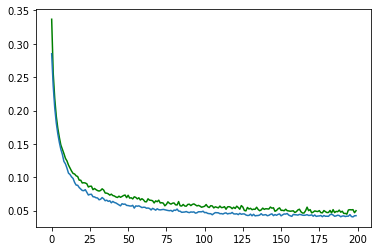

In [12]:
plt.plot(losses_train, 'g')
plt.plot(losses_val)
plt.show()

In [13]:
print(model)

Sequential(
  (0): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=125, out_features=7, bias=True)
  (2): Softmax(dim=1)
)


In [14]:
def plot_weight(tensor):
    fig, ax = plt.subplots(figsize=(30, 50))
    im = ax.imshow(tensor.cpu())

    ax.set_ylim([-0.5,6.5])
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(['Gt', 'Pn', 'Co', 'Cl', 'Ob', 'Tr', 'Vl'])
    ax.set_ylabel('Instrument')
    ax.set_xlabel('Scattering coefficient')
    ax.set_title('Trained weights for the different scattering coefficients')
    plt.show()

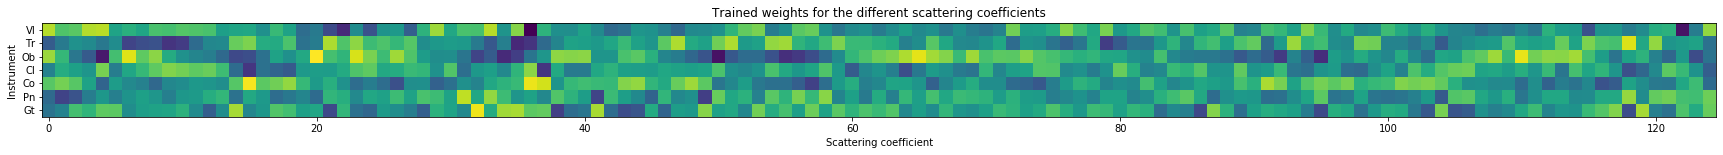

In [15]:
for param in model.parameters():
    if len(param.data.shape)==2:
        plot_weight(param.data)